# Compare PS1 Mean, Forced, Stacked Photometry

This notebook utilizes HST imaging to the COSMOS field, which provides reliable morphological classifications to a magnitude limit of $\sim{26}\,\mathrm{mag}$, to compare the results from a "simple" star-galaxy separation model for the 3 different photometry types extracted from PanSTARRS-1: Mean single-epoch photometry, Forced single-epoch photometry, and Stacked photometry.

In brief, the "simple model" combines the SNR$^2$ weighted-mean of the flux measurements for each filter where the source is detected to create a "white" flux measurement. Classifications are then performed by measuring the distance between individual sources and a slope $\approx 1$ line in the white PSF flux-white Kron flux (or white Ap flux) plane. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,zoomed_inset_axes
import seaborn as sns

from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.nonparametric.api as smnp

from sklearn.model_selection import KFold

%matplotlib inline

In [4]:
ps1_white_phot = fits.getdata("/home/xhall/Documents/PS1CrossMatch/PS1_star_galaxy_adamamiller_COSMOS_compare_white_phot_xhall.fit")

In [5]:
print("Of the {:d} unique sources in the COSMOS cross-match:".format(len(ps1_white_phot)))
print("\tThere are {:d} sources with Mean white phot,".format(sum(~np.isnan(ps1_white_phot["wwMeanPSFFlux"]))))
print("\tThere are {:d} sources with Forced white phot,".format(sum(~np.isnan(ps1_white_phot["wwFPSFFlux"]))))
print("\tThere are {:d} sources with Stacked white phot.".format(sum(~np.isnan(ps1_white_phot["wwPSFFlux"]))))

Of the 80974 unique sources in the COSMOS cross-match:
	There are 42687 sources with Mean white phot,
	There are 80865 sources with Forced white phot,
	There are 75927 sources with Stacked white phot.


For a fair, apples-to-apples comparison, we test the different photometric catalogs using only sources that are common to all 3 methods (`mfs` below). We also compare the results on fainter sources by comparing sources in the Stacked and Forced tables (`fs` below). 

In [6]:
wwMeanPSFKronRatio = ps1_white_phot["wwMeanPSFFlux"]/ps1_white_phot["wwMeanKronFlux"]
wwFPSFKronRatio = ps1_white_phot["wwFPSFFlux"]/ps1_white_phot["wwFKronFlux"]
wwPSFKronRatio = ps1_white_phot["wwPSFFlux"]/ps1_white_phot["wwKronFlux"]

det_mfs = np.where(np.isfinite(wwMeanPSFKronRatio) & 
                   np.isfinite(wwFPSFKronRatio) & 
                   np.isfinite(wwPSFKronRatio))
det_mfs_star = np.where(np.isfinite(wwMeanPSFKronRatio) & 
                        np.isfinite(wwFPSFKronRatio) & 
                        np.isfinite(wwPSFKronRatio) & 
                        (ps1_white_phot["mu_class"] == 2) &
                        (wwMeanPSFKronRatio <= 2.0))
det_mfs_gal = np.where(np.isfinite(wwMeanPSFKronRatio) & 
                        np.isfinite(wwFPSFKronRatio) & 
                        np.isfinite(wwPSFKronRatio) & 
                        (ps1_white_phot["mu_class"] == 1) &
                        (wwMeanPSFKronRatio <= 2.0))

det_fs = np.where(np.isfinite(wwFPSFKronRatio) & 
                  np.isfinite(wwPSFKronRatio))
det_fs_star = np.where(np.isfinite(wwFPSFKronRatio) & 
                       np.isfinite(wwPSFKronRatio) & 
                       (ps1_white_phot["mu_class"] == 2) )
det_fs_gal = np.where(np.isfinite(wwFPSFKronRatio) & 
                      np.isfinite(wwPSFKronRatio) & 
                      (ps1_white_phot["mu_class"] == 1) )

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


#### Examine the PSF to Aperture ratio 

In [7]:
wwMeanPSFApRatio = ps1_white_phot["wwMeanPSFFlux"]/ps1_white_phot["wwMeanApFlux"]
wwFPSFApRatio = ps1_white_phot["wwFPSFFlux"]/ps1_white_phot["wwFApFlux"]
wwPSFApRatio = ps1_white_phot["wwPSFFlux"]/ps1_white_phot["wwApFlux"]

psfap_mfs = np.where(np.isfinite(wwMeanPSFApRatio) & 
                   np.isfinite(wwFPSFApRatio) & 
                   np.isfinite(wwPSFApRatio))
psfap_mfs_star = np.where(np.isfinite(wwMeanPSFApRatio) & 
                        np.isfinite(wwFPSFApRatio) & 
                        np.isfinite(wwPSFApRatio) & 
                        (ps1_white_phot["mu_class"] == 2) &
                        (wwMeanPSFApRatio <= 2.0))
psfap_mfs_gal = np.where(np.isfinite(wwMeanPSFApRatio) & 
                        np.isfinite(wwFPSFApRatio) & 
                        np.isfinite(wwPSFApRatio) & 
                        (ps1_white_phot["mu_class"] == 1) &
                        (wwMeanPSFApRatio <= 2.0))

psfap_fs = np.where(np.isfinite(wwFPSFApRatio) & 
                  np.isfinite(wwPSFApRatio))
psfap_fs_star = np.where(np.isfinite(wwFPSFApRatio) & 
                       np.isfinite(wwPSFApRatio) & 
                       (ps1_white_phot["mu_class"] == 2) )
psfap_fs_gal = np.where(np.isfinite(wwFPSFApRatio) & 
                      np.isfinite(wwPSFApRatio) & 
                      (ps1_white_phot["mu_class"] == 1) )

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


# Part 1 - Bright Sources Detected in Single Exposures

## Plot distance vs. Kron mag for 3 different phot measures

Show the distribution of these sources in their respective PSF vs. Kron planes.

In [9]:
ps1_df = Table.read("/home/xhall/Documents/PS1CrossMatch/PS1_star_galaxy_adamamiller_COSMOS_compare_white_phot_xhall.fit").to_pandas()

ps1_df["MeanDist"] = (ps1_white_phot["wwMeanPSFFlux"] - ps1_white_phot["wwMeanKronFlux"])/np.sqrt(2)
ps1_df["FDist"] = (ps1_white_phot["wwFPSFFlux"] - ps1_white_phot["wwFKronFlux"])/np.sqrt(2)
ps1_df["Dist"] = (ps1_white_phot["wwPSFFlux"] - ps1_white_phot["wwKronFlux"])/np.sqrt(2)

ps1_df["psfapMeanDist"] = (ps1_white_phot["wwMeanPSFFlux"] - ps1_white_phot["wwMeanApFlux"])/np.sqrt(2)
ps1_df["psfapFDist"] = (ps1_white_phot["wwFPSFFlux"] - ps1_white_phot["wwFApFlux"])/np.sqrt(2)
ps1_df["psfapDist"] = (ps1_white_phot["wwPSFFlux"] - ps1_white_phot["wwApFlux"])/np.sqrt(2)

ps1_df["MeanKronMag"] = -2.5*np.log10(ps1_white_phot["wwMeanKronFlux"]/3631)
ps1_df["FKronMag"] = -2.5*np.log10(ps1_white_phot["wwFKronFlux"]/3631)
ps1_df["KronMag"] = -2.5*np.log10(ps1_white_phot["wwKronFlux"]/3631)


In [10]:
def kde_contour_dat(x, y, extent = (0,0,0,0), bw_type = "silverman", grid_bins = 100):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == (0,0,0,0):
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

#### Get KDEs for PSF-Kron phot

In [13]:
gal_dist_mean = ps1_df.iloc[det_mfs_gal]["MeanDist"]
gal_mag_mean = ps1_df.iloc[det_mfs_gal]["MeanKronMag"]

star_dist_mean = ps1_df.iloc[det_mfs_star]["MeanDist"]
star_mag_mean = ps1_df.iloc[det_mfs_star]["MeanKronMag"]

xgal_mean, ygal_mean, zgal_mean = kde_contour_dat(gal_mag_mean, gal_dist_mean, extent = (16,24,-2e-5,2e-5))
xstar_mean, ystar_mean, zstar_mean = kde_contour_dat(star_mag_mean, star_dist_mean, extent = (16,24,-2e-5,2e-5))

gal_dist_forced = ps1_df.iloc[det_mfs_gal]["FDist"]
gal_mag_forced = ps1_df.iloc[det_mfs_gal]["FKronMag"]

star_dist_forced = ps1_df.iloc[det_mfs_star]["FDist"]
star_mag_forced = ps1_df.iloc[det_mfs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (16,24,-2e-5,2e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (16,24,-2e-5,2e-5))

gal_dist_stacked = ps1_df.iloc[det_mfs_gal]["Dist"]
gal_mag_stacked = ps1_df.iloc[det_mfs_gal]["KronMag"]

star_dist_stacked = ps1_df.iloc[det_mfs_star]["Dist"]
star_mag_stacked = ps1_df.iloc[det_mfs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (16,24,-2e-5,2e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (16,24,-2e-5,2e-5))

#### Get KDEs for PSF-Ap phot

In [14]:
gal_dist_mean_psfap = ps1_df.iloc[psfap_mfs_gal]["psfapMeanDist"]
gal_mag_mean_psfap = ps1_df.iloc[psfap_mfs_gal]["MeanKronMag"]

star_dist_mean_psfap = ps1_df.iloc[psfap_mfs_star]["psfapMeanDist"]
star_mag_mean_psfap = ps1_df.iloc[psfap_mfs_star]["MeanKronMag"]

xgal_mean_psfap, ygal_mean_psfap, zgal_mean_psfap = kde_contour_dat(gal_mag_mean_psfap, gal_dist_mean_psfap, extent = (16,24,-2e-5,2e-5))
xstar_mean_psfap, ystar_mean_psfap, zstar_mean_psfap = kde_contour_dat(star_mag_mean_psfap, star_dist_mean_psfap, extent = (16,24,-2e-5,2e-5))

gal_dist_forced_psfap = ps1_df.iloc[psfap_mfs_gal]["psfapFDist"]
gal_mag_forced_psfap = ps1_df.iloc[psfap_mfs_gal]["FKronMag"]

star_dist_forced_psfap = ps1_df.iloc[psfap_mfs_star]["psfapFDist"]
star_mag_forced_psfap = ps1_df.iloc[psfap_mfs_star]["FKronMag"]

xgal_forced_psfap, ygal_forced_psfap, zgal_forced_psfap = kde_contour_dat(gal_mag_forced_psfap, gal_dist_forced_psfap, extent = (16,24,-2e-5,2e-5))
xstar_forced_psfap, ystar_forced_psfap, zstar_forced_psfap = kde_contour_dat(star_mag_forced_psfap, star_dist_forced_psfap, extent = (16,24,-2e-5,2e-5))

gal_dist_stacked_psfap = ps1_df.iloc[psfap_mfs_gal]["psfapDist"]
gal_mag_stacked_psfap = ps1_df.iloc[psfap_mfs_gal]["KronMag"]

star_dist_stacked_psfap = ps1_df.iloc[psfap_mfs_star]["psfapDist"]
star_mag_stacked_psfap = ps1_df.iloc[psfap_mfs_star]["KronMag"]

xgal_stacked_psfap, ygal_stacked_psfap, zgal_stacked_psfap = kde_contour_dat(gal_mag_stacked_psfap, gal_dist_stacked_psfap, extent = (16,24,-2e-5,2e-5))
xstar_stacked_psfap, ystar_stacked_psfap, zstar_stacked_psfap = kde_contour_dat(star_mag_stacked_psfap, star_dist_stacked_psfap, extent = (16,24,-2e-5,2e-5))

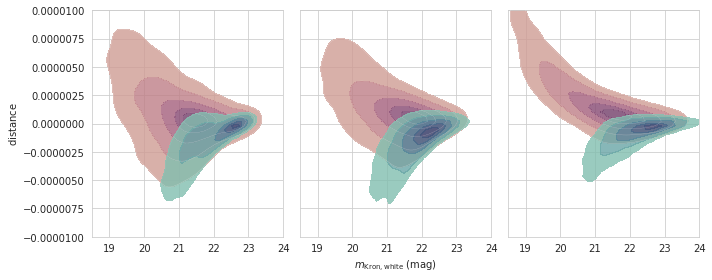

In [15]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_mean, ystar_mean, zstar_mean, xgal_mean, ygal_mean, zgal_mean), 
                                                                     (xstar_forced, ystar_forced, zstar_forced, xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,xgal_stacked, ygal_stacked, zgal_stacked)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 24)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

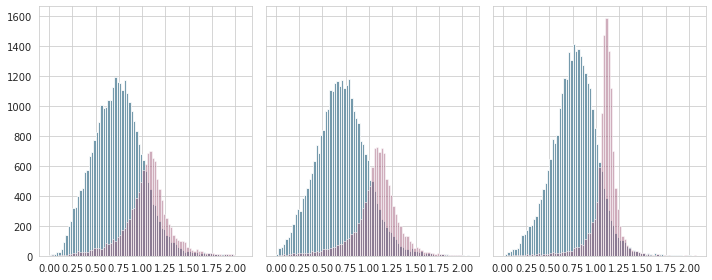

In [16]:
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, flux_ratio in enumerate([wwMeanPSFKronRatio, wwFPSFKronRatio, wwPSFKronRatio]):
        axes[axnum].hist(flux_ratio[det_mfs_gal], 
                         alpha=0.8, bins=np.arange(0,2.1,0.025), 
                         color = cmap_gal(0.6))
        axes[axnum].hist(flux_ratio[det_mfs_star], 
                         alpha=0.5, bins=np.arange(0,2.1,0.025), 
                         color = cmap_star(0.6))
    axes[0].set_xticks(np.linspace(0,2,9))
    fig.tight_layout()

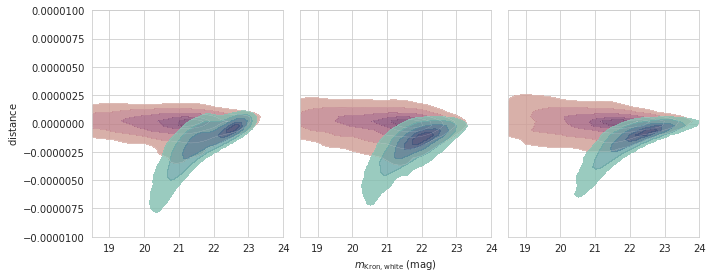

In [17]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_mean_psfap, ystar_mean_psfap, zstar_mean_psfap, xgal_mean_psfap, ygal_mean_psfap, zgal_mean_psfap), 
                                                                     (xstar_forced_psfap, ystar_forced_psfap, zstar_forced_psfap, xgal_forced_psfap, ygal_forced_psfap, zgal_forced_psfap), 
                                                                     (xstar_stacked_psfap, ystar_stacked_psfap, zstar_stacked_psfap, xgal_stacked_psfap, ygal_stacked_psfap, zgal_stacked_psfap)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 24)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

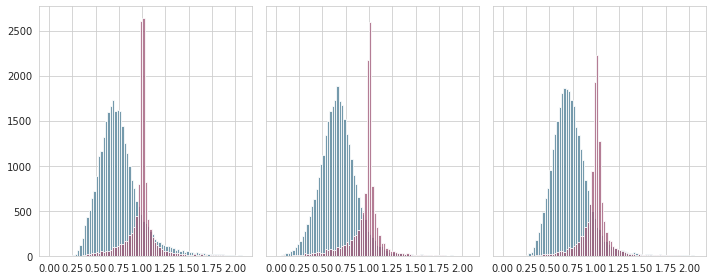

In [18]:
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, flux_ratio in enumerate([wwMeanPSFApRatio, wwFPSFApRatio, wwPSFApRatio]):
        axes[axnum].hist(flux_ratio[det_mfs_gal], 
                         alpha=0.8, bins=np.arange(0,2.1,0.025), 
                         color = cmap_gal(0.6))        
        axes[axnum].hist(flux_ratio[det_mfs_star], 
                         alpha=0.8, bins=np.arange(0,2.1,0.025), 
                         color = cmap_star(0.6))
    axes[0].set_xticks(np.linspace(0,2,9))

    fig.tight_layout()

## Determine the combo of data + slope to maximize TPR at FPR = 0.005

There are 4 numerical quantities that we care about, though ultimately we hope to maximize the TPR at FPR = 0.005.

In [19]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

def calc_distance(a, x, y): # model: y = ax
    a = np.array(a)
    model = (a*x).astype(float)
    wd = (y-model)/np.sqrt(1 + a**2)
    return np.array(wd)

def calc_accuracy(a, flux1, flux2, true_class):
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    pred_class = np.array((np.sign(delta)+1)/2, dtype = int)    # psf = kron >> gal
    acc = accuracy_score(true_class, pred_class)
    return acc

def calc_roc_auc(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    auc = roc_auc_score(true_class, delta)
    return auc

def calc_informedness_and_tpr(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)
    fom = np.interp(0.005, fpr, tpr)
    
    return np.max(tpr-fpr), fom

def calc_roc_curve(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)    
    return fpr, tpr, thre

In [20]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["mean", "forced", "stacked"],
                        ["wwMean", "wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.iloc[det_mfs]['{:s}KronFlux'], 
                                      ps1_df.iloc[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.iloc[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.iloc[det_mfs]["{:s}KronFlux"], 
                                      ps1_df.iloc[det_mfs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.iloc[det_mfs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.iloc[det_mfs]['{:s}KronFlux'], 
                                      ps1_df.iloc[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.iloc[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

Max Acc = 0.8630 at a = 1.0400
Max AUC = 0.9396 at a = 0.8400
Max TPR-FPR = 0.7790 at a = 0.9000
Max FoM = 0.6414 at a = 0.9400


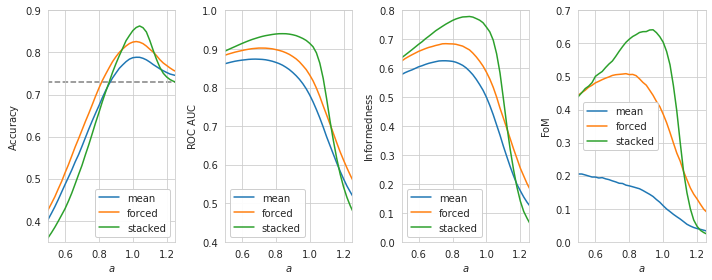

In [21]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["mean", "forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{0}, label='{0}')".format(phot))
        exec("axes[1].plot(a_grid, auc_{0}, label='{0}')".format(phot))
        exec("axes[2].plot(a_grid, inform_{0}, label='{0}')".format(phot))
        exec("axes[3].plot(a_grid, fom_{0}, label='{0}')".format(phot))

    axes[3].set_xlim(0.5,1.25)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
        ax.legend(frameon=True, framealpha=0.95)
    axes[0].plot([0,2], [0.73, 0.73], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

Given that the dataset is dominated by faint sources, it should perhaps not be surprising that the PS1 stacked photometry clearly outperforms the other photometric methods (which have known issues at fainter brightness levels). 

Also interesting is that $a \approx 1$ maximizes each of the metrics that we are interested in determining. For the FoM, the variation near peak is strongly dependent on the selected value of $a$ - **the choice of this value should be confirmed via cross-validation.**

Below, we show that adopting $a = 0.94$ does not strongly degrade the other metrics considered for the simple model. Less than 1% for the ROC stats, and 6% for the accuracy (in particular this last choice leads to 

In [25]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.1085
Delta auc = -0.0013
Delta inform = -0.0024


**Examine same statistics for PSF and Ap Flux**

In [23]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["mean", "forced", "stacked"],
                        ["wwMean", "wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.iloc[det_mfs]['{:s}ApFlux'], 
                                      ps1_df.iloc[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.iloc[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.iloc[det_mfs]["{:s}ApFlux"], 
                                      ps1_df.iloc[det_mfs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.iloc[det_mfs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.iloc[det_mfs]['{:s}ApFlux'], 
                                      ps1_df.iloc[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.iloc[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

Max Acc = 0.8580 at a = 0.9400
Max AUC = 0.9377 at a = 0.7600
Max TPR-FPR = 0.7641 at a = 0.7800
Max FoM = 0.6337 at a = 0.8000


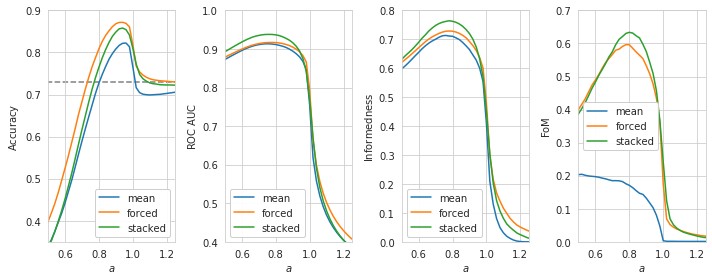

In [24]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["mean", "forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{0}, label='{0}')".format(phot))
        exec("axes[1].plot(a_grid, auc_{0}, label='{0}')".format(phot))
        exec("axes[2].plot(a_grid, inform_{0}, label='{0}')".format(phot))
        exec("axes[3].plot(a_grid, fom_{0}, label='{0}')".format(phot))

    axes[3].set_xlim(0.5,1.25)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
        ax.legend(frameon=True, framealpha=0.95)
    axes[0].plot([0,2], [0.73, 0.73], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

The results when comparing the PSF and Ap photometry yield some interesting results. In particular, the separation between the use of the stacked photometry and the forced photometry is not as prominent (and in the case of overall model accuracy the forced photometry outperforms the stacked photometry).

Beyond that, while the performance of the simple model in the PSF-Ap plane is very similar to the PSF-Kron model, ultimately, the PSF-Kron model performs better (albeit at only a $\sim$1% improvement for the FoM).

As a result, **we conclude that PSF-Kron is the best model for separating stars and galaxies**. 

For completeness, below we examine the changes in the other metrics by adopting $a=0.8$, which maximizes the FoM.

In [26]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.1085
Delta auc = -0.0013
Delta inform = -0.0024


### Stacked Phot ROC curves

Having established that the stacked photometry is the best for PS1, we now examine the ROC curves for the four different metrics considered above.

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


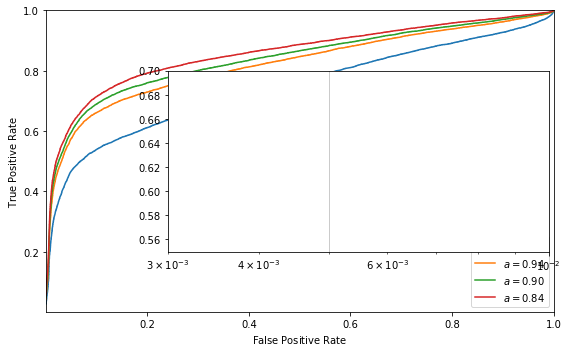

In [31]:
a_choice = [1.04, 0.94, 0.90, 0.84]

fig, ax = plt.subplots(figsize=(8,5))

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

for a in a_choice:
    fpr, tpr, thre = calc_roc_curve(a, ps1_df.iloc[det_mfs]["wwMeanKronFlux"], 
                                    ps1_df.iloc[det_mfs]["wwMeanPSFFlux"], 
                                    np.array(ps1_df.iloc[det_mfs]["mu_class"], dtype = int)-1)
    ax.plot(fpr, tpr, label = r"$a = {:.2f}$".format(a))
    axins.plot(fpr, tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()

From the ROC curves, it is clear that the performance at $a = 0.90$ is better than the FoM maximizing $a = 0.94$, aside from a small (noise?) spike exactly at FPR = 0.005. *This result should still be confirmed via CV or independent train-test split.*

**Thus, we adpot $a = 0.90$ as the optimal threshold for classifying PS1 stars and galaxies.**

To obtain FPR = 0.005 from this model requires a threshold of:

In [32]:
a = 0.90
fpr, tpr, thre = calc_roc_curve(a, ps1_df.iloc[det_mfs]["wwKronFlux"], 
                                ps1_df.iloc[det_mfs]["wwPSFFlux"], 
                                np.array(ps1_df.iloc[det_mfs]["mu_class"], dtype = int)-1)
print("Sources with d > {:.8f} should be classified as stars".format(thre[np.argmin(np.abs(fpr - 0.005))]))


Sources with d > 0.00000185 should be classified as stars


# Part 2 - checking even the faintest sources

Below we will execute the same analysis, but this time using only sources detected in both the Forced and Stacked photometry from PS1. The primary difference for this sample is that it is a factor of $\sim$2 larger because the depth limits of the PS1 mean photometry are $\sim$1 mag more shallow than Forced and Stacked.

In [48]:
gal_dist_forced = ps1_df.iloc[det_fs_gal]["FDist"]
gal_mag_forced = ps1_df.iloc[det_fs_gal]["FKronMag"]

star_dist_forced = ps1_df.iloc[det_fs_star]["FDist"]
star_mag_forced = ps1_df.iloc[det_fs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (17,25.5,-4e-5,4e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (17,25.5,-4e-5,4e-5))

gal_dist_stacked = ps1_df.iloc[det_fs_gal]["Dist"]
gal_mag_stacked = ps1_df.iloc[det_fs_gal]["KronMag"]

star_dist_stacked = ps1_df.iloc[det_fs_star]["Dist"]
star_mag_stacked = ps1_df.iloc[det_fs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (17,25.5,-4e-5,4e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (17,25.5,-4e-5,4e-5))

gal_dist_mean = ps1_df.iloc[det_fs_gal]["MeanDist"]
gal_mag_mean = ps1_df.iloc[det_fs_gal]["MeanKronMag"]

star_dist_mean = ps1_df.iloc[det_fs_star]["MeanDist"]
star_mag_mean = ps1_df.iloc[det_fs_star]["MeanKronMag"]

xgal_mean, ygal_mean, zgal_mean = kde_contour_dat(gal_mag_mean, gal_dist_mean, extent = (17,25.5,-4e-5,4e-5))
xstar_mean, ystar_mean, zstar_mean = kde_contour_dat(star_mag_mean, star_dist_mean, extent = (17,25.5,-4e-5,4e-5))

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


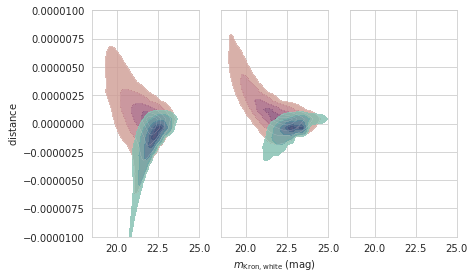

In [55]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (6.7, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_forced, ystar_forced, zstar_forced, 
                                                                      xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,
                                                                      xgal_stacked, ygal_stacked, zgal_stacked),
                                                                    (xstar_mean, ystar_mean, zstar_mean,
                                                                    xgal_mean, ygal_mean, zgal_mean)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 25)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

In [56]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["mean", "forced", "stacked"],
                        ["wwMean", "wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.iloc[det_fs]['{:s}KronFlux'], 
                                      ps1_df.loc[det_fs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.loc[det_fs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.loc[det_fs]["{:s}KronFlux"], 
                                      ps1_df.loc[det_fs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.loc[det_fs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.iloc[det_fs]['{:s}KronFlux'], 
                                      ps1_df.loc[det_fs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.loc[det_fs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Max Acc = 0.8115 at a = 2.0000
Max AUC = 0.9019 at a = 0.8000
Max TPR-FPR = 0.6912 at a = 0.8600
Max FoM = 0.5483 at a = 0.8600


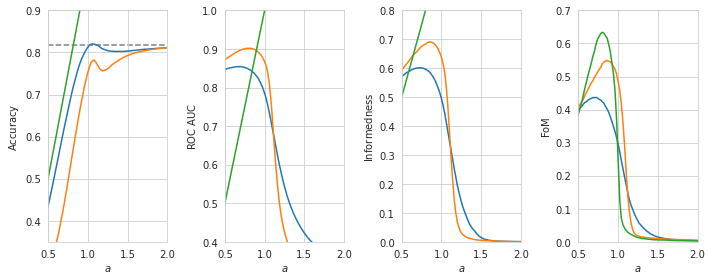

In [57]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["forced", "stacked", "mean"]:
        exec("axes[0].plot(a_grid, acc_{:s})".format(phot))
        exec("axes[1].plot(a_grid, auc_{:s})".format(phot))
        exec("axes[2].plot(a_grid, inform_{:s})".format(phot))
        exec("axes[3].plot(a_grid, fom_{:s})".format(phot))

    axes[3].set_xlim(0.5,2)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
    naive = len(det_fs_gal[0])/len(det_fs[0])
    axes[0].plot([0,2], [naive, naive], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

Because the new sample of faint sources is dominated by galaxies, we find that smaller values for $a$ do a better job with our preferred metrics. We also find that the simple model essentially does not outperform the naive model (i.e. all sources = galaxy).

In [531]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.2371
Delta auc = -0.0021
Delta inform = 0.0000


<IPython.core.display.Javascript object>


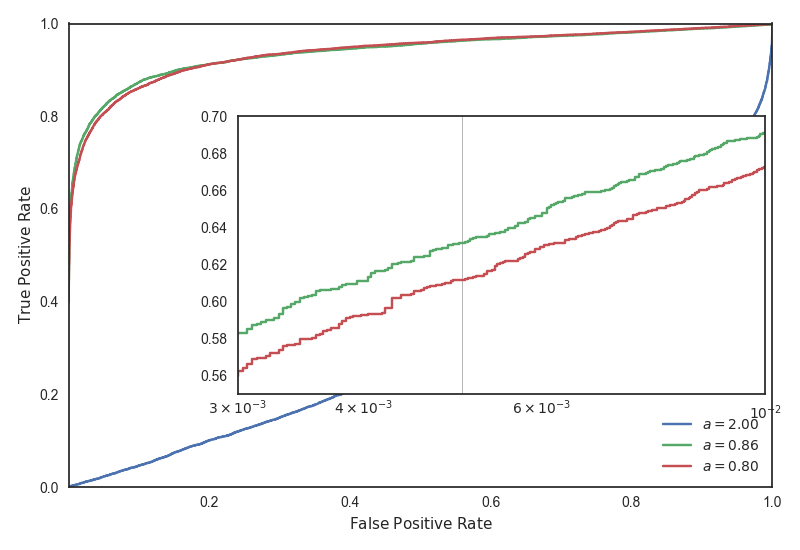

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [532]:
a_choice = [2, 0.86, 0.80]

fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

for a in a_choice:
    fpr, tpr, thre = calc_roc_curve(a, ps1_df.iloc[det_mfs]["wwKronFlux"], 
                                    ps1_df.iloc[det_mfs]["wwPSFFlux"], 
                                    np.array(ps1_df.iloc[det_mfs]["mu_class"], dtype = int)-1)
    ax.plot(fpr, tpr, label = r"$a = {:.2f}$".format(a))
    axins.plot(fpr, tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()

# Part 3

Perform cross-validation to determine the optimal value of $a$ for separating stars and galaxies.

Note - this should use the definition of the training set that is also adopted for the RF machine learning model. This definition is slightly different than that used above (e.g., `det_mfs` required sources to be detected in each of the Mean, Forced, and Stacked photometry tables). This previous subset was needed in order to compare all the same sources between the three different photometry measures. The final model and catalog will be constructed using only Stacked photometry, so the definition for the training set should be adjusted to reflect this. 

As shown below - there are more (faint) sources in the Stacked training set so the performance is slightly different than the number quoted above.

In [18]:
hst_feats = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()
in_ts = np.where(hst_feats["nDetections"] > 0)
hst_ml_y = np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)-1

In [48]:
print("There are {:d} sources in the det_mfs subset".format(len(det_mfs[0])))
print("There are {:d} sources that have nDetections > 0".format(len(in_ts[0])))

There are 42277 sources in the det_mfs subset
There are 47093 sources that have nDetections > 0


With nearly 5k more sources in the true training set, we expect that the optimized model will feature a different value of $a$ and that the overall model performance will be slightly worse as these sources are slightly fainter. (See histograms below).

<IPython.core.display.Javascript object>


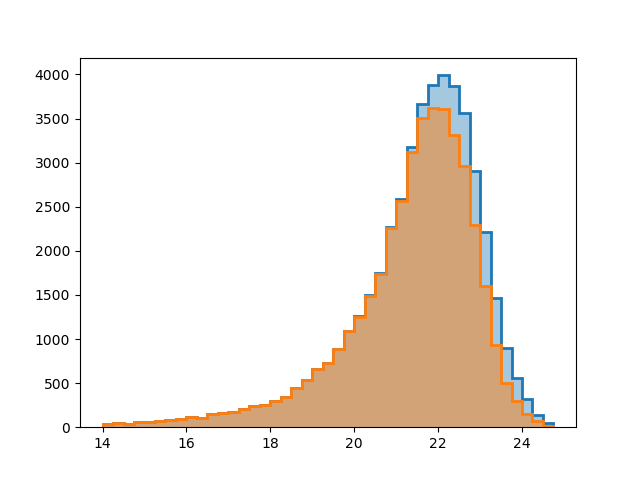

(array([   35.,    43.,    31.,    60.,    57.,    72.,    78.,    89.,
          115.,   101.,   153.,   164.,   176.,   206.,   237.,   257.,
          302.,   346.,   446.,   530.,   659.,   724.,   889.,  1087.,
         1252.,  1491.,  1736.,  2254.,  2560.,  3121.,  3508.,  3615.,
         3614.,  3315.,  2961.,  2288.,  1607.,   932.,   498.,   294.,
          146.,    69.,    17.]),
 array([ 14.  ,  14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,
         16.  ,  16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,
         18.  ,  18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,
         20.  ,  20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,
         22.  ,  22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,
         24.  ,  24.25,  24.5 ,  24.75]),
 <a list of 43 Patch objects>)

In [64]:
fig, ax = plt.subplots()
ax.hist(-2.5*np.log10(hst_feats["wwKronFlux"].iloc[in_ts]/3631), 
        bins = np.arange(14,25,0.25), histtype='step',
        color="C0", lw=2)
ax.hist(-2.5*np.log10(hst_feats["wwKronFlux"].iloc[in_ts]/3631), 
        bins = np.arange(14,25,0.25), color="C0",
        alpha=0.4)
ax.hist(-2.5*np.log10(ps1_df["wwKronFlux"].iloc[det_mfs]/3631), 
        bins = np.arange(14,25,0.25), histtype='step',
        color="C1",lw=2)
ax.hist(-2.5*np.log10(ps1_df["wwKronFlux"].iloc[det_mfs]/3631), 
        bins = np.arange(14,25,0.25), color="C1",
        alpha=0.5)

In [75]:
rs = 23
N_outter_splits = 10
a_grid = np.linspace(0.75, 1.25, 201)

dist_preds = np.empty_like(hst_feats.iloc[in_ts]['MU_CLASS'])
tuned_a = np.empty(N_outter_splits)
fold_acc = np.empty_like(tuned_a)
fold_auc = np.empty_like(tuned_a)
fold_inform = np.empty_like(tuned_a)
fold_fom = np.empty_like(tuned_a)

kf_cv = KFold(n_splits=N_outter_splits, shuffle=True, random_state=rs)

for fold, (train, test) in zip(range(N_outter_splits), kf_cv.split(hst_feats.iloc[in_ts])):
    
    inform_train = np.empty(len(a_grid))
    fom_train = np.empty(len(a_grid))
    for i_a, a in enumerate(a_grid):
        inform_train[i_a], fom_train[i_a] = calc_informedness_and_tpr(a, np.array(hst_feats.iloc[in_ts]['wwKronFlux'])[train], 
                                      np.array(hst_feats.iloc[in_ts]['wwPSFFlux'])[train], 
                                      np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)[train]-1)
        
    opt_a = a_grid[np.argmax(fom_train)]
    tuned_a[fold] = opt_a
    dist_preds[test] = calc_distance(opt_a, np.array(hst_feats.iloc[in_ts]['wwKronFlux'])[test], 
                                     np.array(hst_feats.iloc[in_ts]['wwPSFFlux'])[test])
    fold_acc[fold] = calc_accuracy(opt_a, np.array(hst_feats.iloc[in_ts]['wwKronFlux'])[test], 
                                   np.array(hst_feats.iloc[in_ts]['wwPSFFlux'])[test], 
                                   np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)[test]-1)
    fold_auc[fold] = calc_roc_auc(opt_a, np.array(hst_feats.iloc[in_ts]['wwKronFlux'])[test], 
                                  np.array(hst_feats.iloc[in_ts]['wwPSFFlux'])[test], 
                                  np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)[test]-1)
    fold_inform[fold], fold_fom[fold] = calc_informedness_and_tpr(opt_a, np.array(hst_feats.iloc[in_ts]['wwKronFlux'])[test], 
                                  np.array(hst_feats.iloc[in_ts]['wwPSFFlux'])[test], 
                                  np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)[test]-1)

<IPython.core.display.Javascript object>


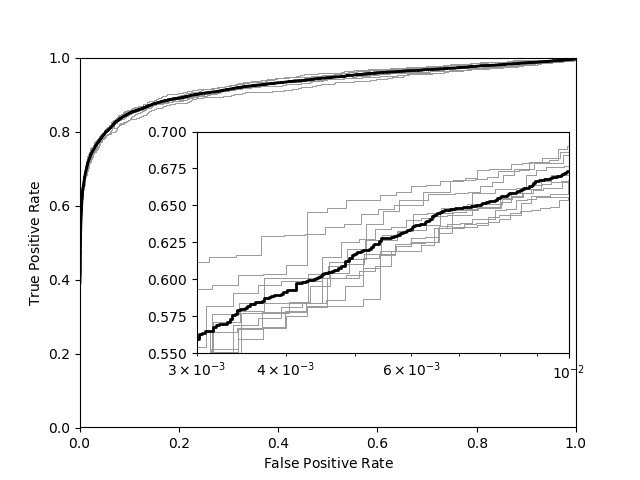

Optimal a = 0.91375
The accuracy is 0.7606 +/- 0.009655
The ROC AUC is 0.9267 +/- 0.005570
The informedness is 0.7536 +/- 0.008133
The FoM is 0.6169 +/- 0.020046


In [74]:
fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

print("Optimal a = {}".format(np.mean(tuned_a)))
fpr, tpr, thre = calc_roc_curve(np.mean(tuned_a), 
                                hst_feats.iloc[in_ts]['wwKronFlux'], 
                                hst_feats.iloc[in_ts]['wwPSFFlux'], 
                                np.array(hst_feats.iloc[in_ts]["MU_CLASS"], dtype = int)-1)

ax.plot(fpr, tpr, "k", lw = 2, zorder=5, label = r"$a = {:.2f}$".format(a))
axins.plot(fpr, tpr, "k", lw = 2, zorder=5)

# plot up the individual folds
for train, test in kf_cv.split(hst_feats.iloc[in_ts]):
    fpr, tpr, thre = roc_curve(np.array(hst_feats.iloc[in_ts]["MU_CLASS"], dtype = int)[test]-1, dist_preds[test])
    ax.plot(fpr, tpr, '-', color="0.6", lw = 0.7)
    axins.plot(fpr, tpr, '-', color="0.6", lw = 0.7)

ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")

# calculate the relevant metrics for the optimal value of a
mean_a = np.mean(tuned_a)
opt_acc = calc_accuracy(mean_a, hst_feats.iloc[in_ts]['wwKronFlux'], 
                        hst_feats.iloc[in_ts]['wwPSFFlux'], 
                        np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)-1)
opt_auc = calc_roc_auc(mean_a, hst_feats.iloc[in_ts]['wwKronFlux'], 
                       hst_feats.iloc[in_ts]['wwPSFFlux'], 
                       np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)-1)
opt_inform, opt_fom = calc_informedness_and_tpr(mean_a, hst_feats.iloc[in_ts]['wwKronFlux'], 
                                                hst_feats.iloc[in_ts]['wwPSFFlux'], 
                                                np.array(hst_feats.iloc[in_ts]['MU_CLASS'], dtype = int)-1)

print("The accuracy is {:.4f} +/- {:4f}".format(opt_acc, np.std(fold_acc)))
print("The ROC AUC is {:.4f} +/- {:4f}".format(opt_auc, np.std(fold_auc)))
print("The informedness is {:.4f} +/- {:4f}".format(opt_inform, np.std(fold_inform)))
print("The FoM is {:.4f} +/- {:4f}".format(opt_fom, np.std(fold_fom)))

The above code performs an outer loop on the training set, which enables the use of all training set sources in the test phase. While there is considerable scatter in the FoM for the individual folds (light grey lines above), the optimal value of $a$ is $\sim$$0.91 \pm 0.01$ for all folds.

**Thus, we adopt $a = 0.91375$ (found above) as the optimal model for our data set.**

With the value of $a$ selected, we now need to determine the optimal value for classification (i.e. maximizing the accuracy). We do this by maximizing the accuracy as a function classification threshold.

In [10]:
wwPSFKronDist = calc_distance(0.91375, hst_feats.iloc[in_ts]['wwKronFlux'], 
                              hst_feats.iloc[in_ts]['wwPSFFlux'])

fpr, tpr, thresh = roc_curve(hst_ml_y, wwPSFKronDist)

acc_array = np.empty_like(thresh)
for thresh_num, class_boundary in enumerate(thresh):
    acc_array[thresh_num] = accuracy_score(hst_ml_y, wwPSFKronDist > class_boundary)

<IPython.core.display.Javascript object>


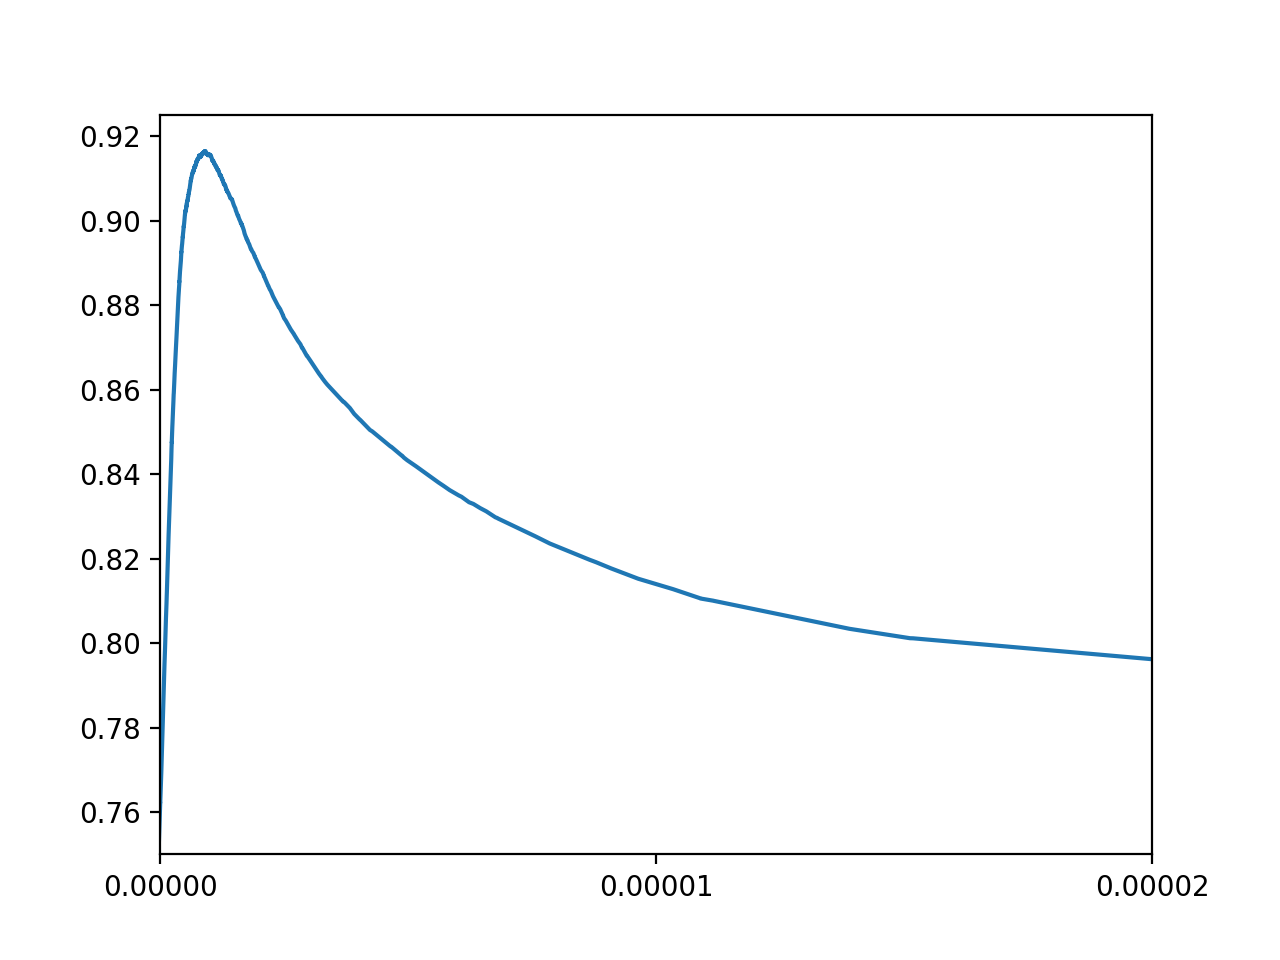

([<matplotlib.axis.XTick at 0x114be8dd8>,
 <a list of 3 Text xticklabel objects>)

In [34]:
plt.plot(thresh, acc_array)
plt.xlim(0,2e-5)
plt.ylim(0.75,0.925)
plt.xticks([0,1e-5,2e-5])

In [33]:
print("The optimal classification threshold is {}".format(thresh[np.argmax(acc_array)]))

The optimal classification threshold is 9.199338089095014e-07
